In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/project3


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# CNN 연습하기 - FOOD

https://www.tensorflow.org/tutorials/images/cnn?hl=ko



In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

from skimage.transform import resize
from skimage.io import imread


from tqdm import tqdm
import pickle

# 병렬연산
from concurrent.futures import ThreadPoolExecutor

import os
import warnings
warnings.filterwarnings(action='ignore')

import cv2
from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split


In [ ]:
### 사용자 정의 함수
%cd /content/drive/MyDrive/project3/

# Add the paths to the modules to the Python path
import sys
sys.path.append(os.path.abspath('./code/image_function'))

from image_load import resize_image, load_image, load_and_resize_images
from vram_reset import reset_vram

# reset_vram() - > vram 초기화

/content/drive/MyDrive/project3


In [ ]:
gpu_available = tf.config.list_physical_devices('GPU')
if gpu_available:
    print("GPU is available")
    print("GPU devices:", gpu_available)
else:
    print("GPU is not available")

GPU is available
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 데이터 준비

In [ ]:
datadir = '/content/drive/MyDrive/project3/data/traindata/kfood2'

food_middle_list = sorted(os.listdir(datadir))
food_middle_list[:5]

['구이', '국', '기타', '김치', '나물']

In [ ]:
food_list = [] # 음식이름
food_path_list = [] # 음식이름 경로

for food_middle in food_middle_list:
    middle_path = os.path.join(datadir,food_middle)
    food_name_list = os.listdir(middle_path)

    for food in food_name_list:
        path = os.path.join(middle_path,food)
        food_path_list.append(path)

        name = path.split('/')[-1]
        food_list.append(name)

print(len(food_list))
print(food_list)
print(food_path_list)

153
['갈비구이', '갈치구이', '고등어구이', '곱창구이', '장어구이', '떡갈비', '더덕구이', '불고기', '조개구이', '삼겹살', '조기구이', '닭갈비', '훈제오리', '황태구이', '계란국', '떡국_만두국', '무국', '미역국', '시래기국', '콩나물국', '육개장', '북엇국', '젓갈', '양념치킨', '과메기', '콩자반', '편육', '피자', '후라이드치킨', '갓김치', '깍두기', '나박김치', '무생채', '배추김치', '백김치', '부추김치', '열무김치', '오이소박이', '파김치', '총각김치', '가지볶음', '시금치나물', '애호박볶음', '고사리나물', '숙주나물', '미역줄기볶음', '경단', '꿀떡', '송편', '만두', '찜', '찌개', '죽', '라면', '막국수', '물냉면', '비빔냉면', '수제비', '열무국수', '콩국수', '짬뽕', '잔치국수', '칼국수', '짜장면', '쫄면', '꽈리고추무침', '도라지무침', '도토리묵', '잡채', '콩나물무침', '회무침', '홍어무침', '누룽지', '김밥', '김치볶음밥', '비빔밥', '새우볶음밥', '알밥', '유부초밥', '

In [ ]:
new_img_size = (100, 100)
pic_count = 10
food_count = 15
food_path_list2 = food_path_list[:food_count]

image_list, target_list, except_list = load_and_resize_images(food_path_list2, food_list, img_size = new_img_size)

In [ ]:
np.savez_compressed('data.npz', image_list=image_list, target_list=target_list)

In [ ]:
data = np.load('data.npz')
image_list = data['image_list']
target_list = data['target_list']

In [ ]:
# target을 숫자로 바꿔서 dictionary 형태로
label_encoder = {label: idx for idx, label in enumerate(np.unique(target_list))}

# 숫자가 key 값인 dict
num_label_encoder = {v: k for k, v in label_encoder.items()}
target_num = np.array([label_encoder[label] for label in target_list], dtype=np.int8)

In [ ]:
label_encoder

{'갈비구이': 0,
 '갈치구이': 1,
 '계란국': 2,
 '고등어구이': 3,
 '곱창구이': 4,
 '닭갈비': 5,
 '더덕구이': 6,
 '떡갈비': 7,
 '불고기': 8,
 '삼겹살': 9,
 '장어구이': 10,
 '조개구이': 11,
 '조기구이': 12,
 '황태구이': 13,
 '훈제오리': 14}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(image_list, target_num, test_size=0.2, random_state=42, stratify = target_list)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1198, 100, 100, 3), (300, 100, 100, 3), (1198,), (300,))

In [ ]:
# 0 ~ 1 값으로 정규화
X_train = X_train / 255.0
X_test = X_test / 255.0

삼겹살


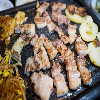

(100, 100, 3)


In [ ]:
pic_num = 20
print(num_label_encoder[y_train[pic_num]])
cv2_imshow(X_train[pic_num] * 255)
print(X_train[pic_num].shape)


In [ ]:
# import gc
# import tensorflow as tf
# from tensorflow.keras.backend import clear_session

# # Function to reset VRAM
# def reset_vram():
#     # Clear the Keras session to release model resources
#     clear_session()

#     # Delete any large variables (example variable `large_data`)
#     try:
#         del large_data
#     except NameError:
#         pass

#     # Perform garbage collection
#     gc.collect()

#     # Check current VRAM usage
#     !nvidia-smi

# # Call the function to reset VRAM
# reset_vram()

# Modeling

입력으로 CNN은 배치 크기를 무시하고 형상(image_height, image_width, color_channels)의 텐서를 사용합니다. 이러한 차원을 처음 접하는 경우 color_channels는 (R,G,B)를 나타냅니다. 이 예에서는 CIFAR 이미지 형식인 형상(32, 32, 3)의 입력을 처리하도록 CNN을 구성합니다. input_shape 인수를 첫 번째 레이어에 전달하여 이를 수행할 수 있습니다.

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3))) # input_shape 들어가는 사진의 크기
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 64)        36928     
                                                                 
Total params: 56320 (220.00 KB)
Trainable params: 5632

모델을 완성하려면 마지막 합성곱 층의 출력 텐서(크기 (4, 4, 64))를 하나 이상의 Dense 층에 주입하여 분류를 수행합니다. Dense 층은 벡터(1D)를 입력으로 받는데 현재 출력은 3D 텐서입니다. 먼저 3D 출력을 1D로 펼치겠습니다. 그다음 하나 이상의 Dense 층을 그 위에 추가하겠습니다. MNIST 데이터는 10개의 클래스가 있으므로 마지막에 Dense 층에 10개의 출력과 소프트맥스 활성화 함수를 사용합니다

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(food_count)) # class num

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 64)        36928     
                                                                 
 flatten_1 (Flatten)         (None, 28224)            

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics='accuracy')

history = model.fit(X_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
30/30 [==============================] - 6s 40ms/step - loss: 2.7125 - accuracy: 0.1075 - val_loss: 2.6438 - val_accuracy: 0.1000
Epoch 2/10
30/30 [==============================] - 0s 13ms/step - loss: 2.4592 - accuracy: 0.1743 - val_loss: 2.4704 - val_accuracy: 0.1500
Epoch 3/10
30/30 [==============================] - 0s 12ms/step - loss: 2.3079 - accuracy: 0.2662 - val_loss: 2.4259 - val_accuracy: 0.2125
Epoch 4/10
30/30 [==============================] - 0s 13ms/step - loss: 2.1414 - accuracy: 0.2871 - val_loss: 2.3056 - val_accuracy: 0.2875
Epoch 5/10
30/30 [==============================] - 0s 12ms/step - loss: 1.8700 - accuracy: 0.4008 - val_loss: 2.4881 - val_accuracy: 0.1833
Epoch 6/10
30/30 [==============================] - 0s 12ms/step - loss: 1.6192 - accuracy: 0.4708 - val_loss: 2.5435 - val_accuracy: 0.2333
Epoch 7/10
30/30 [==============================] - 0s 12ms/step - loss: 1.2929 - accuracy: 0.5898 - val_loss: 2.7928 - val_accuracy: 0.2583
Epoch 8/10
30

10/10 - 0s - loss: 4.4335 - accuracy: 0.2467 - 255ms/epoch - 26ms/step


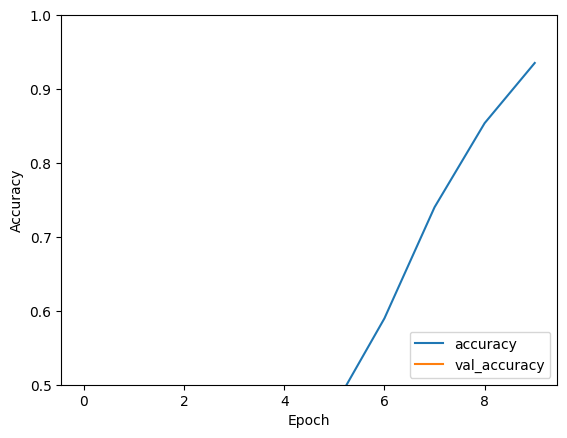

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

In [ ]:
predictions = model.predict(X_test)

# Convert the logits to probabilities
probabilities = tf.nn.softmax(predictions)

# Get the class with the highest probability
predicted_classes = np.argmax(probabilities, axis=1)

# Compare the predicted classes with the actual classes
comparison = list(zip(predicted_classes, y_test))

# Display the first 10 predictions and actual values
for i in range(20):
    print(f'Predicted: {predicted_classes[i]}, Actual: {y_test[i]}')

10/10 [==============================] - 0s 4ms/step
Predicted: 8, Actual: 5
Predicted: 1, Actual: 4
Predicted: 1, Actual: 11
Predicted: 8, Actual: 14
Predicted: 13, Actual: 13
Predicted: 5, Actual: 10
Predicted: 10, Actual: 14
Predicted: 0, Actual: 0
Predicted: 4, Actual: 3
Predicted: 10, Actual: 14
Predicted: 7, Actual: 7
Predicted: 10, Actual: 5
Predicted: 3, Actual: 4
Predicted: 10, Actual: 3
Predicted: 7, Actual: 4
Predicted: 5, Actual: 6
Predicted: 3, Actual: 1
Predicted: 2, Actual: 2
Predicted: 12, Actual: 1
Predicted: 5, Actual: 5
